In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
import itertools
import string
import collections
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MBTI_AUG.csv")
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,INTP,'Good one _____ https://www.youtube.com/wat...
2,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
3,INTJ,'18/37 @.@|||Science is not perfect. No scien...
4,INFJ,"'No, I can't draw on my own nails (haha). Thos..."


In [ ]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 39.6 MB/s eta 0:00:00


In [ ]:
def convert_to_lower(text):
    return text.lower()

def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    removed = []
    stop_words = list(stopwords.words("english"))
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stop_words:
            removed.append(tokens[i])
    return " ".join(removed)

def remove_extra_white_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

In [ ]:
df['posts'] = df['posts'].apply(lambda x: convert_to_lower(x))
df['posts'] = df['posts'].apply(lambda x: remove_numbers(x))
df['posts'] = df['posts'].apply(lambda x: remove_punctuation(x))
df['posts'] = df['posts'].apply(lambda x: remove_stopwords(x))
df['posts'] = df['posts'].apply(lambda x: remove_extra_white_spaces(x))
df['posts'] = df['posts'].apply(lambda x: lemmatizing(x))

In [ ]:
df.head()

,type,posts
0,INFJ,httpwwwyoutubecomwatchvqsxhcwe krwhttp mediatu...
1,INTP,good one httpswwwyoutubecomwatchvfhigbolffgwof...
2,INTJ,dear intp enjoyed conversation day esoteric ga...
3,INTJ,science perfect scientist claim scientific inf...
4,INFJ,cant draw nail haha done professional nail yes...


In [ ]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd

from sklearn.preprocessing import LabelEncoder

# Load your dataset into a DataFrame 'df' if not already loaded
label_encoder = LabelEncoder()
df['type_encoded'] = label_encoder.fit_transform(df['type'])

# Training loop
num_epochs = 10 # Adjust as needed
best_val_accuracy = 0.0

# Split the dataset into train, validation, and test sets
train_data, val_test_data = train_test_split(df, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(val_test_data, test_size=0.5, random_state=42)

# Extract text and labels from the dataset
train_texts = train_data['posts'].tolist()
train_labels = train_data['type_encoded'].tolist()
val_texts = val_data['posts'].tolist()
val_labels = val_data['type_encoded'].tolist()
test_texts = test_data['posts'].tolist()
test_labels = test_data['type_encoded'].tolist()

# Set the device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=16) # 16 classes

model.to(device)

# Tokenize and convert text data to tensors
def tokenize_and_encode(texts, labels, tokenizer):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,  # Adjust as needed
            padding="max_length",
            truncation=True,
            return_tensors="pt",
            return_attention_mask=True,
        )
        input_ids.append(encoded_dict["input_ids"])
        attention_masks.append(encoded_dict["attention_mask"])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    return torch.utils.data.TensorDataset(input_ids, attention_masks, labels)

# Create DataLoader for training, validation, and test sets
batch_size = 32  # Adjust as needed
train_dataset = tokenize_and_encode(train_texts, train_labels, tokenizer)
val_dataset = tokenize_and_encode(val_texts, val_labels, tokenizer)
test_dataset = tokenize_and_encode(test_texts, test_labels, tokenizer)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define training parameters
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataloader) * num_epochs,
)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping to prevent exploding gradients
        optimizer.step()
        scheduler.step()

    # Validation
    model.eval()
    val_predictions = []
    val_true_labels = []

    with torch.no_grad():
        for batch in val_dataloader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, labels = batch

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            val_predictions.extend(preds.tolist())
            val_true_labels.extend(labels.tolist())

    val_accuracy = accuracy_score(val_true_labels, val_predictions)
    print(f"Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {val_accuracy}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), "best_distilbert_model.pt")

# Load the best model and evaluate on the test set
model.load_state_dict(torch.load("best_distilbert_model.pt"))
model.eval()

test_predictions = []
test_true_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        test_predictions.extend(preds.tolist())
        test_true_labels.extend(labels.tolist())

test_accuracy = accuracy_score(test_true_labels, test_predictions)
print(f"Test Accuracy: {test_accuracy}")

# Optional: Print classification report for more detailed evaluation
class_names = ["INFP","INFJ","INTP","INTJ","ENTP","ENFP","ISTP","ISFP","ENTJ","ISTJ","ENFJ","ISFJ","ESTP","ESFP","ESFJ","ESTJ"]  # Define your 16 personality types
report = classification_report(test_true_labels, test_predictions, target_names=class_names)
print(report)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10 - Validation Accuracy: 0.5014475969889982
Epoch 2/10 - Validation Accuracy: 0.6421540243196294
Epoch 3/10 - Validation Accuracy: 0.6803705848291836
Epoch 4/10 - Validation Accuracy: 0.7185871453387377
Epoch 5/10 - Validation Accuracy: 0.7272727272727273
Epoch 6/10 - Validation Accuracy: 0.7301679212507238
Epoch 7/10 - Validation Accuracy: 0.7429067747539085
Epoch 8/10 - Validation Accuracy: 0.7371163867979155
Epoch 9/10 - Validation Accuracy: 0.7411696583671106
Epoch 10/10 - Validation Accuracy: 0.7469600463231036
Test Accuracy: 0.7384259259259259
              precision    recall  f1-score   support

        INFP       0.89      0.92      0.90        92
        INFJ       0.65      0.62      0.63       115
        INTP       0.89      0.93      0.91        96
        INTJ       0.72      0.57      0.64       117
        ENTP       0.99      1.00      0.99        84
        ENFP       0.99      0.99      0.99        94
        ISTP       0.99      0.99      0.99       100
  

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
precision = precision_score(test_true_labels, test_predictions, average='weighted')
recall = recall_score(test_true_labels, test_predictions, average='weighted')
f1 = f1_score(test_true_labels, test_predictions, average='weighted')

print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1-Score: {f1}")

Test Precision: 0.7420648637934877
Test Recall: 0.7384259259259259
Test F1-Score: 0.7377398205434103


In [ ]:
import matplotlib.pyplot as plt

def plot_classification_results(test_data, test_predictions):
    correctly_classified_by_type = {}
    misclassified_by_type = {}

    for text, true_label, predicted_label in zip(test_data['posts'], test_data['type_encoded'], test_predictions):
        if true_label == predicted_label:
            if true_label not in correctly_classified_by_type:
                correctly_classified_by_type[true_label] = 0
            correctly_classified_by_type[true_label] += 1
        else:
            if true_label not in misclassified_by_type:
                misclassified_by_type[true_label] = 0
            misclassified_by_type[true_label] += 1

    # Define personality type labels
    personality_types = ["INFP", "INFJ", "INTP", "INTJ", "ENTP", "ENFP", "ISTP", "ISFP", "ENTJ", "ISTJ", "ENFJ", "ISFJ", "ESTP", "ESFP", "ESFJ", "ESTJ"]

    # Create data for stacked bar chart
    correctly_classified_counts = [correctly_classified_by_type[label] if label in correctly_classified_by_type else 0 for label in range(16)]
    misclassified_counts = [misclassified_by_type[label] if label in misclassified_by_type else 0 for label in range(16)]

    # Create stacked bar chart with custom colors
    plt.figure(figsize=(5, 5))
    plt.bar(personality_types, correctly_classified_counts, label='Correctly Classified', color='lightblue',width=0.25)
    plt.bar(personality_types, misclassified_counts, bottom=correctly_classified_counts, label='Misclassified', color='dodgerblue',width=0.25)
    plt.xlabel('Personality Type')
    plt.ylabel('Number of Instances')
    plt.title('Classification Results for DistilBERT')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.legend()
    plt.show()

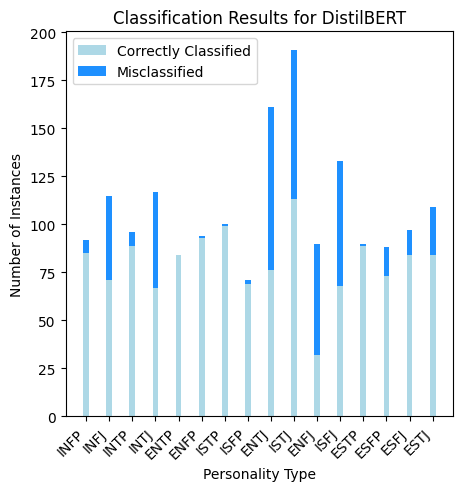

In [ ]:
plot_classification_results(test_data, test_predictions)